## Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# distributions
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
from scipy.stats import invgamma
from scipy.stats import levy
from scipy.special import gamma, erfinv

import time
from datetime import datetime, timedelta

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line
import seaborn as sns

import os

In [2]:
sys.path.append('../tools')
import tools

In [3]:
importlib.reload(tools)

<module 'tools' from '../tools/tools.py'>

## Download Data

In [4]:
df = pd.read_csv('data/apple_cleaned.csv')

## Estimate Spot Volatility

In [ ]:
1+1

In [5]:
# decide whether you use sample or not
sample = False

if sample:
    data = df[df['date']< '2017-01-20']
    
else:
    data = df.copy()

In [6]:
# Plot style
widths = [1,1,1,1,2]
types = ['solid','dashed','dashdot','dotted', 'dotted']

In [7]:
gs =  [ 0.5, 1, 2, 4]

### By bins

#### Near 0

In [8]:
ts = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001]

#### Pdf and Cdf

In [10]:
##### check the for loop, is it actually doing what it is supposed to d
#sigma_hats_ts = []
f_hats_ts = []
F_hats_ts= []

# subset the dataframe
t_g_ws = np.array(data['delta_ts']) 
    

# for each t
for t in ts:
    
    # estimate f_hat, F_hat
    f_hats = []
    F_hats = []
    sigma_hats = []
    
    # start_time for current iteration
    start_time = time.time()
    

    # calculate f_hat
    f_hat = tools.f_hat_t(t, t_g_ws, n = len(t_g_ws))
    f_hats.append(f_hat)

    # calculate F_hat
    F_hat = tools.F_hat_t(t, t_g_ws, n = len(t_g_ws))
    F_hats.append(F_hat)

    # estimate sigma_hat
    #sigma_hat_bin_i = tools.sigma_hat_t(f_hat_bin_i, F_hat_bin_i, g)[0]
    #sigma_hats.append(sigma_hat_bin_i)    
    
    
    # store the estimates
    f_hats_ts.append(f_hats)
    F_hats_ts.append(F_hats)
    #sigma_hats_ts.append(sigma_hats)

    # show the end time
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for t = {t}")

Time : 71.59074401855469 for t = 1e-06
Time : 78.56548309326172 for t = 5e-06
Time : 93.71168899536133 for t = 1e-05
Time : 78.71460890769958 for t = 5e-05
Time : 612.2769939899445 for t = 0.0001


#### Spot Volatility

In [22]:
sigma_hats_gs = []

for g_i, g in zip(range(0, len(gs)), gs):
    
    sigma_hats_ts = []
    # for each t
    for i, t in zip(range(0, len(ts)),ts):
    
        # store the estimates
        f_hats = f_hats_ts[i]
        F_hats = F_hats_ts[i]
        
        sigma_hats_t = tools.sigma_hat_t(f_hats, F_hats, g)
        sigma_hats_ts.append(sigma_hats_t)
        
    sigma_hats_gs.append(sigma_hats_ts)
    
    

#### Summary Stats

In [23]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]

# list to store summaries
summaries = []

# for each t
for i, t in zip(range(0, len(ts)),ts):
    
    # store the estimates
    f_hats = f_hats_ts[i]
    F_hats = F_hats_ts[i]
    sigma_hats = sigma_hats_ts[i]
    
    # calculate summary stats
    f_stats = tools.estimation_summary(f_hats, summary_stats, rounding = 10)
    F_stats = tools.estimation_summary(F_hats, summary_stats, rounding = 10)
    # create a dataframe
    summary_t = pd.DataFrame([f_stats, F_stats],columns =  ['Mean', 'Median','Std', '5.0%', '95%'],
                            index = [np.tile(t, 2) , ['$\widehat{f}$', '$\widehat{F}$']])
    
    summary_t.index.set_names(['t', 'Statistics'], inplace = True)
    
    # store the summary
    summaries.append(summary_t)

    


In [24]:
pd.concat(summaries)

Mean       Median  Std         5.0%  \
t        Statistics                                                  
0.000001 $\widehat{f}$  1127.753185  1127.753185  0.0  1127.753185   
         $\widehat{F}$     0.171096     0.171096  0.0     0.171096   
0.000005 $\widehat{f}$  1139.534421  1139.534421  0.0  1139.534421   
         $\widehat{F}$     0.175634     0.175634  0.0     0.175634   
0.000010 $\widehat{f}$  1143.821106  1143.821106  0.0  1143.821106   
         $\widehat{F}$     0.181345     0.181345  0.0     0.181345   
0.000050 $\widehat{f}$  1101.137667  1101.137667  0.0  1101.137667   
         $\widehat{F}$     0.226437     0.226437  0.0     0.226437   
0.000100 $\widehat{f}$  1004.650479  1004.650479  0.0  1004.650479   
         $\widehat{F}$     0.279200     0.279200  0.0     0.279200   

                                95%  
t        Statistics                  
0.000001 $\widehat{f}$  1127.753185  
         $\widehat{F}$     0.171096  
0.000005 $\widehat{f}$  1139.534421  
         $\widehat{F}$     0.175634  
0.000010 $\widehat{f}$  1143.821106  
         $\widehat{F}$     0.181345  
0.000050 $\widehat{f}$  1101.137667  
         $\widehat{F}$     0.226437  
0.000100 $\widehat{f}$  1004.650479  
         $\widehat{F}$     0.279200

In [25]:
print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',
                        float_format="%.2f",
#                         formatters = {'Mean': "{:.2E}".format,
#                                       'Median': "{:.2E}".format,
#                                       'Std': "{:.2E}".format,
#                                       '5.0%': "{:.2E}".format,
#                                       '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{llrrrrr}
\caption{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$}\\
\toprule
         &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endfirsthead
\caption[]{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$} \\
\toprule
         &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.000001 & $\widehat{f}$ & 1127.75 & 1127.75 & 0.00 & 1127.75 & 1127.75 \\
         & $\widehat{F}$ &    0.17 &    0.17 & 0.00 &    0.17 &    0.17 \\
0.000005 & $\widehat{f}$ & 1139.53 & 1139.53 & 0.00 & 1139.53 & 1139.53 \\
         & $\widehat{F}$ &    0.18 &    0.18 & 0.00 &    0.18 &    0.18 \\
0.000010 & $\widehat{f}$ & 1143.82 & 11

<ipython-input-25-1f51fe3585d4>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',


In [26]:
# summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]
# # in indices, add sample size and etc
# summaries = []


# for g_i, g in zip(range(0, len(gs)), gs):
    
#     sigma_hats_g = sigma_hats_gs[g_i]
    
#     # for each t
#     for i, t in zip(range(0, len(ts)),ts):
        
#         sigma_hats = sigma_hats_g[i]
        
#         sigma_hats_stats = tools.estimation_summary(sigma_hats, summary_stats, rounding = 10)

#         # create a dataframe
#         summary_t = pd.DataFrame([sigma_hats_stats],
#                                  columns = ['Mean', 'Median', 'Std', '5.0%', '95%'],
#                                  index = [np.tile(g, 1), np.tile(t, 1) , 
#                                           ['$\widehat{\sigma}_{t}$']])



#         summary_t.index.set_names(['g','t'], inplace = True)


In [27]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]
summaries = []

# Initialize gs, ts, and sigma_hats_gs variables with appropriate values

# Iterate over groups
for g_i, g in enumerate(gs):
    sigma_hats_g = sigma_hats_gs[g_i]

    # Iterate over time periods
    for i, t in enumerate(ts):
        sigma_hats = sigma_hats_g[i]

        # Calculate summary statistics
        sigma_hats_stats = tools.estimation_summary(sigma_hats, summary_stats, rounding=10)

        # Create a dataframe
        summary_t = pd.DataFrame([sigma_hats_stats],
                                 columns=['Mean', 'Median', 'Std', '5.0%', '95%'],
                                 index=pd.MultiIndex.from_tuples([(g, t, '$\widehat{\sigma}_{t}$')],
                                                                 names=['g', 't', 'Statistics']))

        summaries.append(summary_t)

In [28]:
print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',
                        float_format="%.2f",
                        formatters = {'Mean': "{:.2E}".format,
                                      'Median': "{:.2E}".format,
                                      #'Bias': "{:.2E}".format,
                                      'Std': "{:.2E}".format,
                                      '5.0%': "{:.2E}".format,
                                      '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lllrrrrr}
\caption{Summary statistics of Empirical Estimate of Volatility with different g}\\
\toprule
    &          &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endfirsthead
\caption[]{Summary statistics of Empirical Estimate of Volatility with different g} \\
\toprule
    &          &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.5 & 0.000001 & $\widehat{\sigma}_{t}$ & 7.03E+02 & 7.03E+02 & 0.00E+00 & 7.03E+02 & 7.03E+02 \\
1.0 & 0.000001 & $\widehat{\sigma}_{t}$ & 2.81E+03 & 2.81E+03 & 0.00E+00 & 2.81E+03 & 2.81E+03 \\
2.0 & 0.000001 & $\widehat{\sigma}_{t}$ & 1.13E+04 & 1.13E+04 & 0.00E+00 & 1.13E+04 & 1.13E+

<ipython-input-28-24462e836325>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',


#### Plots

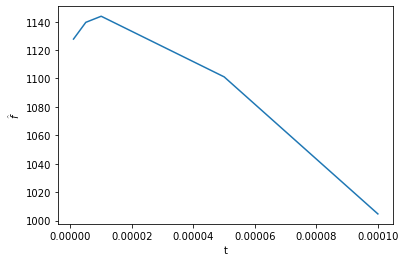

In [38]:
# make some plots
plt.plot(ts, np.mean(f_hats_ts, axis = 1))
plt.ylabel('$\widehat{f}$')
plt.xlabel('t')
#plt.legend()

plt.savefig('figures/distributions/pdf_near_0', facecolor='w')
plt.show()
plt.close()


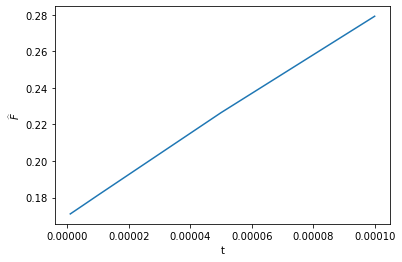

In [39]:
### Plotting F_hat
plt.plot(ts, np.mean(F_hats_ts, axis = 1))
plt.ylabel('$\widehat{F}$')
plt.xlabel('t')
#plt.legend()

plt.savefig('figures/distributions/cdf_near_0', facecolor='w')
plt.show()
plt.close()




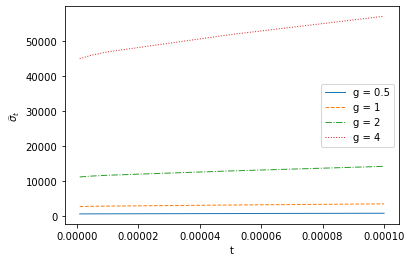

In [37]:
for g_i in range(0, len(gs)):
    
    plt.plot(ts, np.nanmean(sigma_hats_gs[g_i], axis = 1),
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
    
    
plt.ylabel('$\widehat{\sigma}_{t}$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma_near_0', facecolor='w')
plt.show()
plt.close()

In [34]:
sigma_hats_gs[0]

[[703.2562120149461],
 [719.2523020958183],
 [733.343534476521],
 [810.3413910041154],
 [892.2699279444311]]